# SE/2015/026

# S. PRASANTH

## PREDICT AND GIVE QUANTITATIVE SCORE FOR COVID-19 USING CHEST CT IMAGES

In [1]:
# pip install pydicom

In [2]:
import pydicom #For working with DICOM files
import os #For operating system dependend functionality
import pandas as pd #Data analysis and manipulation tool
import numpy as np #Package for linear algebra and multidimentional arrays
import tensorflow as tf #Deep learning tool
import cv2 #Image processing library

from sklearn.model_selection import train_test_split #For split the dataset into trained and test dataset
from sklearn.metrics import f1_score #F1 score
from sklearn.metrics import confusion_matrix #Confusion matrix

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import inspect
from tqdm import tqdm

import tensorflow.keras.backend as K #Transfer learning

#Build model
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

#GRAD-CAM
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import argparse
import imutils

## LOAD CSV DATA

In [3]:
#Load Trained Meta Dataset
trainedMetaData = pd.read_csv('../Dataset/CSV/CT Trained Metadata.csv', index_col=1)

trainedMetaData.head()

,Id,Dataset_type,Result,Image_Names
Label,,,,
ARDS,0,TRAIN,0,ARDS (1).jpg
ARDS,1,TRAIN,0,ARDS (2).jpg
COVID-19,2,TRAIN,1,Covid-19 (1).jpeg
COVID-19,3,TRAIN,1,Covid-19 (2).jpeg
COVID-19,4,TRAIN,1,Covid-19 (3).jpeg


In [4]:
#Trained dataset count
len(trainedMetaData)

5354

In [5]:
#Load Test Meta Dataset
testMetaData = pd.read_csv('../Dataset/CSV/CT Test Metadata.csv', index_col=1)

testMetaData.head()

,Id,Dataset_type,Image_Names
Label,,,
COVID-19,5377,TEST,Covid-19 (106).jpg
COVID-19,5378,TEST,Covid-19 (107).jpg
COVID-19,5379,TEST,Covid-19 (108).jpg
COVID-19,5380,TEST,Covid-19 (109).jpg
COVID-19,5381,TEST,Covid-19 (110).jpg


In [6]:
#Test dataset count
len(testMetaData)

599

## DATA PRE-PROCESSING

In [7]:
#Check for Null Values in Trained Meta Dataset
trainedMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5354 entries, ARDS to Streptococcus
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            5354 non-null   int64 
 1   Dataset_type  5354 non-null   object
 2   Result        5354 non-null   int64 
 3   Image_Names   5354 non-null   object
dtypes: int64(2), object(2)
memory usage: 209.1+ KB


In [8]:
#Check for Data duplications in Trained Meta Dataset
trainedMetaData.duplicated().sum()

0

In [9]:
#Check for Null Values in Test Meta Dataset
testMetaData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 599 entries, COVID-19 to SARS
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            599 non-null    int64 
 1   Dataset_type  599 non-null    object
 2   Image_Names   599 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.7+ KB


In [10]:
#Check for Data duplications in Test Meta Dataset
trainedMetaData.duplicated().sum()

0

In [11]:
#Summary of Whole Meta Dataset
metaSummaryData = pd.read_csv('../Dataset/CSV/CT Metadata Summary.csv', index_col=1)

metaSummaryData.head(8)

,Label
Image_Count,
117,COVID-19
1576,Normal
2,ARDS
2773,Pnemonia Bacteria
1469,Pnemonia Virus
11,SARS
5,Streptococcus
5953,Total


## DISPLAY CT IMAGE

In [27]:
#Function to display Image
def ShowCTImage(titleNoise, titleNoiseRemoval, image):
    image_noise = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_denoise = cv2.GaussianBlur(image,(5,5),0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(12,10))
    
    ax1.imshow(image_noise,cmap='gray')
    ax2.imshow(img_denoise,cmap='gray')
    
    ax1.set_title(titleNoise)
    ax1.grid(False)
    
    ax2.set_title(titleNoiseRemoval)
    ax2.grid(False)

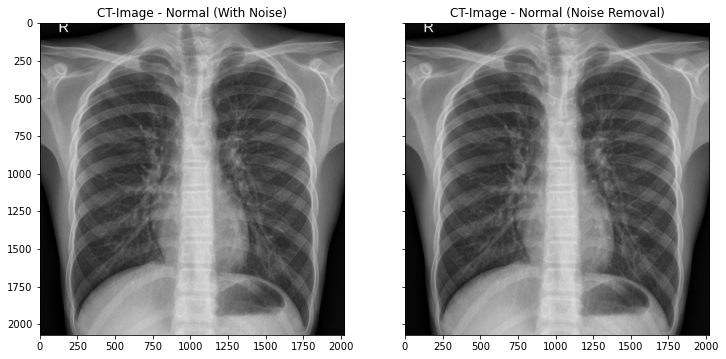

In [28]:
#Call diplay Healthy Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Normal (33).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Normal (With Noise)", "CT-Image - Normal (Noise Removal)", image)

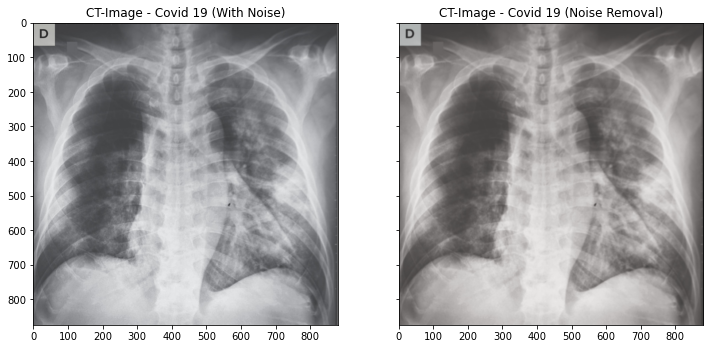

In [29]:
#Call diplay Covid-19 Patient's Chest CT Image
fileName = "../Dataset/CT/TRAIN/Covid-19 (5).jpeg"
image = cv2.imread(fileName)
ShowCTImage("CT-Image - Covid 19 (With Noise)", "CT-Image - Covid 19 (Noise Removal)", image)

## LOAD IMAGES

In [ ]:
trainedImageArray = []
imageSize = 224
testImageArray = []

#Load and resize trained images
for i in range(len(trainedMetaData)):
    imgPath = "../Dataset/CT/TRAIN/" + trainedMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    trainedImageArray.append([newImgArray, trainedMetaData['Result'][i]]) #Load trained images into an array

In [ ]:
#Load and resize test images
for i in range(len(testMetaData)):
    imgPath = "../Dataset/CT/TEST/" + testMetaData['Image_Names'][i] #Image path
    
    img = cv2.imread(imgPath) #Read image
    imgArray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert image color to RGB
    newImgArray = cv2.resize(imgArray, (imageSize, imageSize)) #Resize image
    
    testImageArray.append(newImgArray) #Load trained images into an array

In [ ]:
#Suffle trained images
np.random.shuffle(trainedImageArray)

x = []
y = []

for image in trainedImageArray:
    x.append(image[0])
    y.append(image[1])

#Convert x and y to numpy array
x = np.array(x)
y = np.array(y)

In [ ]:
#Train-Test split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

## KERAS PROCESSING

In [ ]:
numOfTrainedData = len(list(X_train))
numOfTrainedValidation = len(list(X_val))
numOfClasses = 1
batchSize = 32
numOfIterations = int(numOfTrainedData / batchSize) #Assume batch size is 32 for trained and test validation

modelBenchMark = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}

model_dictionary = {m[0]: m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_dictionary

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)

train_generator = train_datagen.flow(X_train, y_train, batch_size = batchSize)

val_generator = val_datagen.flow(X_val, y_val, batch_size = batchSize)

In [ ]:
# for model_name, model in tqdm(model_dictionary.items()):
    
#     #Special handling for "NASNetLarge" since it requires input images with size (331, 331)
#     if model_name != "NASNetLarge":
#         input_shape = (224, 224, 3)
#         train_processed = X_train
#         validation_processed = X_val
        
#     #Load the pre-trained model with global average as the last layer and freeze the model weights
#     preTrainedModel = model(include_top = False, pooling = 'avg', input_shape = (224, 224, 3))
#     preTrainedModel.trainable = False
    
#     #Custom modification on top of pre-trained model
#     clfModel = tf.keras.models.Sequential()
#     clfModel.add(preTrainedModel)
#     clfModel.add(tf.keras.layers.Dense(numOfClasses, activation = 'sigmoid'))
#     clfModel.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
#     history = clfModel.fit(train_generator, epochs = 3, validation_data = val_generator, steps_per_epoch = numOfIterations)
    
#     #Calculate all relevant metrices
#     modelBenchMark['model_name'].append(model_name)
#     modelBenchMark['num_model_params'].append(preTrainedModel.count_params())
#     modelBenchMark['validation_accuracy'].append(history.history['val_accuracy'][-1])

    

In [ ]:
#Convert Results to dataframe
# benchMarkDF = pd.DataFrame(modelBenchMark)
# benchMarkDF.sort_values('num_model_params', inplace = True) #Ascending order
# benchMarkDF.to_csv('Benchmark_DataFrame', index = False) #Write results into csv file

# benchMarkDF

### TRANSFER LEARNING

In [ ]:
# def get_f1(yTrue, yPred):
#     truePositives = K.sum(K.round(K.clip(yTrue * yPred, 0, 1)))
#     possiblePositives = K.sum(K.round(K.clip(yTrue, 0, 1)))
#     predictedPositives = K.sum(K.round(K.clip(yPred, 0, 1)))
    
#     precision = truePositives / (predictedPositives + K.epsilon())
#     recall = truePositives / (possiblePositives + K.epsilon())
    
#     f1Val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
#     return f1Val

In [ ]:
# cbs = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 1, min_lr = 1e-5, verbose = 0),
#        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-6, patience = 10, verbose = 1, mode = 'auto')]

### BUILD MODEL

In [ ]:
# def buildModel():
#     model = Sequential()
    
#     conv_base = DenseNet201(input_shape = (224, 224, 3), include_top = False, pooling = 'max', weights = 'imagenet')
    
#     model.add(conv_base)
#     model.add(BatchNormalization())
#     model.add(Dense(2048, activation = 'relu', kernel_regularizer = l1_l2(0.01)))
#     model.add(BatchNormalization())
#     model.add(Dense(1, activation = 'sigmoid'))
    
#     for layer in model.layers:
#         layer.trainable = True
        
#     model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 1e-4), metrics = ['accuracy', get_f1])
    
#     return model

In [ ]:
# model = buildModel()
# model.summary()

### TRAIN MODEL

In [ ]:
# history = model.fit(
#                     train_generator, 
#                     steps_per_epoch = len(X_train) // batchSize, 
#                     validation_data = val_generator, 
#                     validation_steps = len(X_val) // batchSize, 
#                     epochs = 20, 
#                     callbacks = cbs,
#                     class_weight = {0:1, 1:2}
#                 )

### EVALUATE VALIDATION DATA

In [ ]:
# preds = model.predict(X_val / 255.0)
# predictions = []
# f1Score = []
# threshold_dict = {}

# for i in preds:
#     if i > 0.5:
#         predictions.append(1)
#     else :
#         predictions.append(0)
        
# fScore = f1_score(y_val, predictions)

# print(fScore)

In [ ]:
# #Confusion Matrix
# conMatrix = confusion_matrix(y_val, predictions)
# sns.heatmap(conMatrix, annot = True, fmt = '.2f', xticklabels = ['Non_Covid-19', 'Covid-19'], yticklabels = ['Non_Covid-19', 'Covid-19'])

### GRAD_CAM CLASS

In [ ]:
# class GradCAM:
#     def _init_(self, model, classIdx, layerName = None):
#         self.model = model
#         self.classIdx = classIdx
#         self.layerName = layerName
        
#         if self.layerName is None:
#             self.layerName = self.find_target_layer()
            
#     def find_target_layer(self):
#         for layer in reversed(self.model.layers):
#             if len(layer.output_shape) == 4:
#                 return layer.name
            
#         raise ValueError("Could not find 4D layer, Cannot apply GradCAM")
        
#     def compute_heatmap(self, image, eps = 1e-8):
#         gradModel = Model(
#                         inputs = [self.model.input],
#                         outputs = [self.model.get_layer(self.layerName).output, self.model.output]
#                     )
        
#         with tf.GradientTape() as tape:
#             inputs = tf.cast(image, tf.float32)
#             (convOutputs, predictions) = gradModel(inputs)
#             loss = predictions[:, self.classIdx]
            
#         grads = tape.gradient(loss, convOutputs)
        
#         castConvOutputs = tf.cast(convOutputs > 0, "float32")
#         castGrads = tf.cast(grads > 0, "float32")
#         guidedGrads = castConvOutputs * castGrads * grads
        
#         weights = tf.reduce_mean(guidedGrads, axis = (0, 1))
#         cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis = -1)
        
#         (w, h) = (image.shape[2], image.shape[1])
#         heatmap = cv2.resize(cam.numpy(), (w, h))
        
#         numer = heatmap - np.min(heatmap)
#         denom = (heatmap.max() - heatmap.min()) + eps
#         heatmap = numer / denom
#         heatmap = (heatmap * 225).astype("uint8")
        
#         return heatmap
    
#     def overlay_heatmap(self, heatmap, image, alpha = 0.5, colormap = cv2.COLORMAP_VIRIDIS):
#         heatmap = cv2.applyColorMap(heatmap, colormap)
#         output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
#         return (heatmap, output)

### GENERATE HEATMAPS FOR COVID-19 AND NON_COVID-19 X-RAYS

In [ ]:
# covidImgPath = "../Dataset/CT/TRAIN/" + trainedMetaData['Image_Names']

# covidImages = trainedMetaData[trainedMetaData['Result'] == 1][covidImgPath].values.tolist()
# nonCovidImages = trainedMetaData[trainedMetaData['Result'] == 0][covidImgPath].values.tolist()